# Creating a audio pipeline for Urban Sounds

###  Goal of the notebook
This notebook is a pipeline for audio classification. With the notebook you can record an audio sample and do audio classification with CLAP.

### The Audio Pipeline
1. Record an audio sample
2. Audio classification using CLAP
3. Data analysis on the sample
4. Store the results as .json



## 0. Install packages

In [19]:
#!pip install pyaudio

In [1]:
#!pip install soundfile

In [2]:
#!pip install librosa

In [3]:
#!pip install datasets

In [4]:
#%pip install datasets\[audio\]

In [5]:
pip install numpy==1.26

Note: you may need to restart the kernel to use updated packages.


In [6]:
#check python version
import platform
print(platform.python_version())

#Check os version (uncomment if necessary)
print(platform.system())
#platform.linux_distribution()

3.12.2
Darwin


In [ ]:
#basic python packages
import numpy as np
print(f'numpy={np.__version__}')
import IPython
print(f'ipython={IPython.__version__}')
import matplotlib.pyplot as plt
print(f'matplotlib= {plt.__version__}')
import os



numpy=1.26.0
ipython=8.27.0
matplotlib= 3.9.2


In [ ]:
#audio packages
import soundfile
print(f'soundfile={soundfile.__version__}')
import librosa
print(f'librosa={librosa.__version__}')
import librosa.display
import pyaudio
print(f'pyaudio= {pyaudio.__version__}')


soundfile=0.9.0
librosa=0.10.2.post1
pyaudio= 0.2.14


In [ ]:
#deep learning packages
#import torch
#print(f'torch= {torch.__version__}')

import transformers
print(f'transformers={transformers.__version__}')

datasets=3.1.0
transformers=4.48.3


## 1. Take audio sample and save it

In [ ]:
import pyaudio
import wave
import datetime
import os

def record_audio(duration=10, output_folder="samples"):
    # Set the filename based on current time
    current_time = datetime.datetime.now()
    WAVE_OUTPUT_FILENAME = current_time.strftime("%Y-%m-%d_%H-%M-%S") + ".wav"

    # Audio recording parameters
    chunk = 1024
    format = pyaudio.paInt16
    channels = 1
    rate = 48000

    # Initialize PyAudio
    audio = pyaudio.PyAudio()

    # Open stream
    stream = audio.open(format=format, channels=channels,
                        rate=rate, input=True,
                        frames_per_buffer=chunk)

    print("Recording...")

    frames = []

    # Record for the specified duration
    for _ in range(0, int(rate / chunk * duration)):
        data = stream.read(chunk)
        frames.append(data)

    print("Recording finished.")

    # Stop and close the stream
    stream.stop_stream()
    stream.close()
    audio.terminate()

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Define the output filename with the output folder
    WAVE_OUTPUT_FILENAME = os.path.join(output_folder, WAVE_OUTPUT_FILENAME)

    # Save the recorded data as a WAV file
    with wave.open(WAVE_OUTPUT_FILENAME, 'wb') as wf:
        wf.setnchannels(channels)
        wf.setsampwidth(audio.get_sample_size(format))
        wf.setframerate(rate)
        wf.writeframes(b''.join(frames))

    print(f"Audio sample saved as {WAVE_OUTPUT_FILENAME}")
    
    return WAVE_OUTPUT_FILENAME

# Calling the function to record audio
filename = record_audio()

Recording...
Recording finished.
Audio sample saved as samples/2025-02-25_15-31-09.wav


In [23]:
IPython.display.Audio(filename)

## 2. Classify the audio sample


In [12]:
#Select the sample. Uncomment if necessary. 

wav_file_path = filename
#wav_file_path = "./samples/2025-02-10_12-14-34.wav"
#wav_file_path = "./samples/2025-02-24_19-59-01.wav"

In [25]:
# With the similarity search approach of CLAP we can now use a whole range of labels 
def generate_labels_list():
    labels_list =['Gunshot', 'Alarm', 'Moped', 'Car', 'Motorcycle', 'Claxon', 'Slamming door', 'Screaming', 'Talking','Music', 'Birds', 'Airco', 'Noise', 'Silence']
    return labels_list

generate_labels_list()

['Gunshot',
 'Alarm',
 'Moped',
 'Car',
 'Motorcycle',
 'Claxon',
 'Slamming door',
 'Screaming',
 'Talking',
 'Music',
 'Birds',
 'Airco',
 'Noise',
 'Silence']

In [ ]:
#function for audio classification
#%%timeit

def audio_classification(wav_file_path, labels_list):
    """
    Classify an audio file based on a list of candidate labels using a zero-shot audio classification model.
    """
    try:
        # Read the audio file
        audio, samplerate = sf.read(wav_file_path)

        # Initialize the audio classifier pipeline
        audio_classifier = pipeline(task="zero-shot-audio-classification", model="laion/larger_clap_general")

        # Perform classification
        output = audio_classifier(audio, candidate_labels=labels_list)

        return output

    except FileNotFoundError:
        return "Error: The specified audio file was not found."
    except Exception as e:
        return f"An error occurred: {e}"

#call the function
result = audio_classification(wav_file_path, labels_list)

print(f'First result is {result[0]['label']}: {result[0]['score']}')
print(f'Second result is {result[1]['label']}: {result[1]['score']}')
print(f'Third result is {result[2]['label']}: {result[2]['score']}')
IPython.display.Audio(wav_file_path, rate=48000)


Device set to use cpu


First result is Talking: 0.9911165237426758
Second result is Airco: 0.00805954821407795
Third result is Birds: 0.0005801867810077965


## 3. Data analysis on the sample

In [ ]:
# load audio sample and calculate peak-to-peak value

def load_audio_sample(wav_file_path):
    # Load the sample with librosa
    y, sr = librosa.load(wav_file_path)
    return y, sr

def calculate_ptp(y):
    # Load the sample with librosa

    # Calculate the peak-to-peak value
    ptp_value = float(np.ptp(y))
    ptp_value = round(ptp_value, 4)

    print(f"Peak-to-peak value: {ptp_value}")
    return ptp_value

# Call the functions
y, sr = load_audio_sample(wav_file_path)
ptp_value = calculate_ptp(y)

Peak-to-peak value: 0.1408


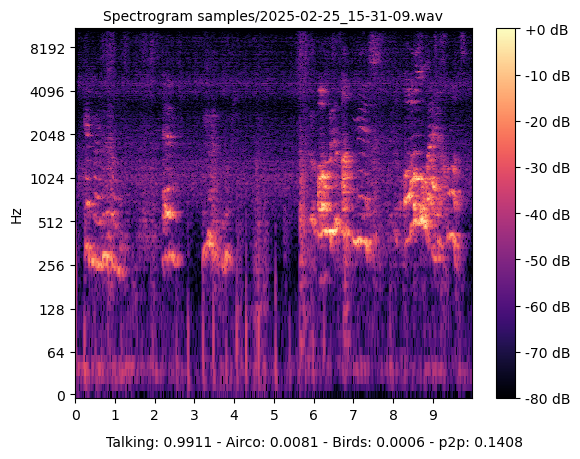

In [24]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # or "true"

def create_spectrogram(wav_file_path, result, ptp_value):
    
    y, sr = librosa.load(wav_file_path)
    spec = np.abs(librosa.stft(y, hop_length=512))
    spec = librosa.amplitude_to_db(spec, ref=np.max)

    plt.figure()
    librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram {wav_file_path}', fontsize=10)

    # Caption with multiple lines
    caption = (f"{result[0]['label']}: {round(result[0]['score'], 4)} - "
               f"{result[1]['label']}: {round(result[1]['score'], 4)} - "
               f"{result[2]['label']}: {round(result[2]['score'], 4)} - "
               f'p2p: {ptp_value}')
    plt.figtext(0.5, 0.01, caption, ha="center", fontsize=10)

    # Show plot
    plt.xlabel('')
    plt.show()

# Example usage
create_spectrogram(wav_file_path, result, ptp_value)

## 4. Store in a .json file (to do: add spectrogram and p2p)

In [18]:
#store the results in a .json file
import json

# Check if the results.json file exists
if os.path.exists('results.json'):
    # Load the existing JSON data
    with open('results.json', 'r') as f:
        results = json.load(f)
else:
    # If the file doesn't exist, start with an empty dict
    results = {}

# Define the new .wav file and its output
new_entry = {
    'filename': filename,
    'result': result[:3], #result of the classification
    'p2p': ptp_value
}
# Add new_entry without overwriting existing keys
for key, value in new_entry.items():
    if key in results:
        # If the key exists, store the values as a list
        if not isinstance(results[key], list):
            results[key] = [results[key]]  # Convert to list if not already
        results[key].append(value)  # Append the new value
    else:
        results[key] = value  # Add new key-value pair
print(results)

# Save the updated results back to the JSON file
with open('results.json', 'w') as f:
    json.dump(results, f, indent=4)

{'filename': ['samples/2025-02-10_20-38-14.wav', 'samples/2025-02-10_20-38-14.wav', 'samples/2025-02-24_14-09-15.wav', 'samples/2025-02-25_09-16-57.wav', 'samples/2025-02-25_13-48-41.wav', 'samples/2025-02-25_15-31-09.wav'], 'result': [{'score': 0.47123515605926514, 'label': 'Screaming'}, {'score': 0.4594155550003052, 'label': 'Silence'}, {'score': 0.04919607192277908, 'label': 'Airco'}, {'score': 0.006231608800590038, 'label': 'Claxon'}, {'score': 0.003251154674217105, 'label': 'Slamming door'}, {'score': 0.0030473489314317703, 'label': 'Talking'}, {'score': 0.0026044670958071947, 'label': 'Birds'}, {'score': 0.001197557314299047, 'label': 'Gunshot'}, {'score': 0.0011828267015516758, 'label': 'Car'}, {'score': 0.0008081781561486423, 'label': 'Motorcycle'}, {'score': 0.0007839786121621728, 'label': 'Moped'}, {'score': 0.0005850164452567697, 'label': 'Music'}, {'score': 0.00025111058494076133, 'label': 'Noise'}, {'score': 0.0002098860131809488, 'label': 'Alarm'}, [{'score': 0.4712351560